# VE-DKL using Mixed models

Here use combine variational encoding with DKL. This is used to segregate samples in the latent space of the DKL. The method using Mixed-LSTMCNN as the neural net initializer.

# Imports

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset

In [ ]:
# Import GP and BoTorch functions
import gpytorch as gpt
from botorch.models import SingleTaskGP, ModelListGP

#from botorch.models import gpytorch
# from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from gpytorch.models import ExactGP
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from smt.sampling_methods import LHS
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

In [3]:

from GP_functions import *
from custom_models import *
from ICCD_Dataset import *
from Plot_DKL_predictions import *

# Functions

In [4]:

def norm_0to1_tensor(X):

    norm_tensor = torch.empty_like(X)

    for i in range(X.shape[-1]):
        torch_i = X[:, i]
        norm_i = (torch_i - torch.min(torch_i))/(torch.max(torch_i) - torch.min(torch_i))
        norm_tensor[:, i] = norm_i
           
    return norm_tensor

def extract_data(dataloader, norm = True):
    images = []
    params =[]
    scores = []
    indices = []

    for i, (images_i, params_i, score_i) in enumerate(dataloader):

        images.append(images_i)
        params.append(params_i)
        scores.append(score_i)

        indices.append(i)

    

    images = torch.cat(images, axis=0)
    params = torch.cat(params, axis=0)
    scores = torch.cat(scores, axis=0)
    indices = np.array(indices)
    

    if norm:
        params = norm_0to1_tensor(params)
        scores = norm_0to1_tensor(scores)

    return images, params, scores, indices


def append_to_train(X, y, params, X_train, y_train, train_params, train_indices, ind):
    X_train = torch.cat((X_train, X[ind:ind+1]), axis=0)
    y_train = torch.cat((y_train, y[ind:ind+1]), axis=0)
    train_params = torch.cat((train_params, params[ind:ind+1]), axis=0)
    train_indices = np.hstack((train_indices, ind))

    return X_train, y_train, train_params, train_indices

def plot_training_loss(training_loss, testing_loss):
    plt.figure(figsize = (4,4))
    plt.semilogy(training_loss, label = 'Train Loss')
    plt.semilogy(testing_loss, label = 'Test Loss')
    plt.ylabel("Epoch loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
def plot_latent_space(embeddings, score = None, lat_order = [0, 1, 2], save_img_path = None):
    
    n = embeddings.shape[0]
    dim = embeddings.shape[1]
    
    l1 = embeddings[:, lat_order[0]]
    l2 = embeddings[:, lat_order[1]]
    l3 = embeddings[:, lat_order[2]]

    
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    if score is not None:
        a = ax.scatter(l1, l2, l3, c=score, alpha=0.7, cmap = 'inferno')  # edgecolors='#1f77b4
        cbar = plt.colorbar(a)
        cbar.set_label(r"Score", size = 12)
 
    else:
        
        ax.scatter(l1, l2, l3, c=score, alpha =0.2)

    ax.set_title('Latent space')
    
    
    
    
    
    if save_img_path is not None:
        plt.savefig(save_img_path, bbox_inches = 'tight')        
    
    
    plt.show()


In [5]:
def veDKL_posterior(model, X_space, params = None):

    """
    Calculate the posterior mean and variance of the DKL model
    To use posterior function, the gp_model should be inherited from GPyTorchModel

    params is the additional parameters that are required for the mixed_nn models
    """
    
    # move the model and the data to the device.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    
    model.eval()
    
    X_space = X_space.to(device)

    if params is not None:
        params = params.to(device)

    
    # Initialize the shape of the predictions
    y_pred_means = torch.empty(len(X_space), 1)
    
    y_pred_vars = torch.empty(len(X_space), 1)
    
    t_X = torch.empty_like((X_space[0]))
    
    t_X = t_X.unsqueeze(0)
    
    latent_embeddings_list = []
    
    
    for t in range(0, len(X_space)):
    
        with torch.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
            gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False,
                                                      solves=True), \
            gpt.settings.max_cg_iterations(100), \
            gpt.settings.max_preconditioner_size(80), \
            gpt.settings.num_trace_samples(128):

                t_X = X_space[t:t+1]
                t_X.to(device)

                if params is not None:
                    t_params = params[t:t+1]
                    t_params = t_params.to(device)
                    predict_embeddings, _, _ = model.custom_nn(t_X, t_params)
                
                else:
                    predict_embeddings, _, _ = model.custom_nn(t_X)
                
                latent_embeddings_list.append(predict_embeddings)
                y_predictions = model.gp.posterior(predict_embeddings)
                y_pred_means[t, 0] = y_predictions.mean
                y_pred_vars[t, 0] = y_predictions.variance
               
            
    latent_embeddings = torch.cat(latent_embeddings_list, dim = 0)        
                    
    return y_pred_means, y_pred_vars, latent_embeddings

In [6]:
from custom_models import RCNN_FeatureExtractor, Mixed_RCNN_FeatureExtractor, DKL_VE_Custom_nn, VE_Mixed_RCNN_FeatureExtractor

In [7]:
def vae_loss_mse(output, train_spectra, beta_elbo = 1e-3):
    
    pred_spectra, mu, logvar = output  
    
    # Reconstruction Loss (Mean Squared Error)
    recon_loss = F.mse_loss(pred_spectra, train_spectra, reduction='mean')

    # KL Divergence Loss (Regularization)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta_elbo*kl_loss

def vae_custom_loss(output, train_y, loss_fn, beta_elbo = 1e-5):
        
    pred_label, mu, logvar = output  
    
    recon_loss = -loss_fn(pred_label, train_y.squeeze(-1))  #default reduction of mll is "sum"
    
    # KL Divergence Loss (Regularization)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta_elbo*kl_loss


def vae_separation_loss(output, train_y, embeddings, loss_fn, beta_elbo = 1e-5, lambda_c = 0.1, lambda_s = 0.1, margin_c = 0):
        
    pred_label, mu, logvar = output  
    
    recon_loss = -loss_fn(pred_label, train_y.squeeze(-1))  #default reduction of mll is "sum"
    
    # KL Divergence Loss (Regularization)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    
    #Cluster embeddings and get the labels:
    
    #labels = get_kmeans_clusters(embeddings, 2)
    
    #Contrastive loss (n_clusters = 2)
    #c_loss = contrastive_loss(embeddings, labels, margin  = margin_c)
    
    #Separation loss
    #s_loss = separation_loss(mu, labels)
    
    
    return recon_loss + beta_elbo*kl_loss #+ lambda_c*c_loss+lambda_s*s_loss


def get_kmeans_clusters(z, num_clusters=2):
    """
    Apply K-Means clustering to latent space representations.
    
    Args:
        z (torch.Tensor): Latent representations (batch_size, latent_dim).
        num_clusters (int): Number of clusters.

    Returns:
        torch.Tensor: Cluster labels (batch_size,).
    """
    z_np = z.detach().cpu().numpy()  # Convert to NumPy for KMeans
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    labels = kmeans.fit_predict(z_np)  # Get cluster assignments
    return torch.tensor(labels, dtype=torch.long, device=z.device)



def separation_loss(mu, labels, alpha=1.0):
    """
    Encourages separation between cluster means in the latent space.
    
    Args:
        mu (torch.Tensor): Latent means (batch_size, latent_dim).
        labels (torch.Tensor): Cluster labels (batch_size,).
        alpha (float): Weight factor for the separation term.
    
    Returns:
        torch.Tensor: Separation loss.
    """
    unique_labels = labels.unique()
    cluster_means = []
    
    # Compute mean vectors for each cluster
    for label in unique_labels:
        cluster_means.append(mu[labels == label].mean(dim=0))
    
    cluster_means = torch.stack(cluster_means)
    pairwise_dist = torch.cdist(cluster_means, cluster_means, p=2)
    
    # Penalize small distances between cluster centers
    loss = torch.exp(-alpha * pairwise_dist).sum()
    return loss




def contrastive_loss(z, labels, margin = 0):
    """
    Computes the contrastive loss for a batch of latent vectors.
    
    Args:
        z (torch.Tensor): Latent representations of shape (batch_size, latent_dim).
        labels (torch.Tensor): Cluster labels of shape (batch_size,).
        margin (float): Distance margin for negative pairs.
    
    Returns:
        torch.Tensor: Contrastive loss.
    """
    batch_size = z.shape[0]

    # Step 1: Compute Pairwise Euclidean Distance
    pairwise_dist = torch.cdist(z, z, p=2)  # (batch_size, batch_size)

    # Step 2: Create Label Mask (1 if same cluster, 0 otherwise)
    labels_expanded = labels.unsqueeze(1)  # (batch_size, 1)
    same_cluster = (labels_expanded == labels_expanded.T).float()  # (batch_size, batch_size)

    # Step 3: Compute Loss Terms
    positive_pairs = same_cluster * pairwise_dist ** 2  # Minimize for same cluster # Sqare offers better gradients
    negative_pairs = (1 - same_cluster) * F.relu(margin - pairwise_dist) ** 2  # Push apart different clusters 

    # Step 4: Compute Final Loss (Normalize)
    loss = positive_pairs.mean() + negative_pairs.mean()
    return loss





In [8]:
def train_test_mixed_nn_veDKL(train_dataset, test_dataset, custom_nn, lr_custom_nn = 0.1, lr_gp = 0.1, num_epochs = 200, 
                              precision = 'double', device = None, plot_loss = False, n_batches = 3, weight_decay = 0, beta_elbo = 0):
    
        if device is None:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
                device = device

        
        initialize_dataloader = DataLoader(train_dataset, batch_size = len(train_dataset), shuffle = False)
        train_dataloader = DataLoader(train_dataset, batch_size = len(train_dataset)//n_batches, shuffle = True)
        test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset)//n_batches, shuffle = True)
        

        for train_X, train_params, train_Y in initialize_dataloader:
            # Load the data to the device
            train_X, train_params, train_Y = train_X.to(device), train_params.to(device), train_Y.to(device)
      


            
      

        #Construct the joint model
          #Extract features from the custom_nn
        custom_nn.to(device)
        embeddings, _, _ = custom_nn(train_X, train_params)
          # Define the GP model, Embed the features
        likelihood = GaussianLikelihood()
        gp = SimpleGP(embeddings, train_Y.squeeze(-1), likelihood = likelihood) #.squeeze(-1) to match with gp.train_targets
        gp.to(device)
       
        # Define the joint DKL model
        model = DKL_VE_Custom_nn(custom_nn, gp)
        model.to(device)
    

        # Define the optimizer for the joint model
        optimizer = Adam([
            {'params': model.custom_nn.parameters(), 'lr': lr_custom_nn, 'weight_decay':weight_decay},
            {'params': model.gp.parameters(), 'lr': lr_gp, 'weight_decay':weight_decay}])


        #Register noise constraint (noise variance is always >= 0.1) to prevent degenerate solutions that may lead to overfitting
        model.gp.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))

        # Define the loss criterion
        mll = ExactMarginalLogLikelihood(likelihood, model.gp)
        mll = mll.to(device)


        # set gp precision to double
        if precision == 'double':
            model.gp = model.gp.double()
        elif precision == 'single':
            model.gp = model.gp.float()
        else:
            raise ValueError('Precision should be either double or single')
        
       


        progress_bar = tqdm(total=num_epochs, desc="Training", leave=False)
        training_loss = []
        testing_loss = []

        for epoch in range(num_epochs):
                
                #Training the model
                epoch_loss = 0
                for train_X, train_params, train_Y in train_dataloader:
                     
                    train_X, train_params, train_Y = train_X.to(device), train_params.to(device), train_Y.to(device)

                
                    # Set the model to training mode
                    model.train()

                    # clear gradients
                    optimizer.zero_grad()
                    
                    # forward pass through the custom_nn to obtain the embeddings
                    embeddings, mu, logvar = model.custom_nn(train_X, train_params) #.to(device)
                    
                    #Reinitialize the model with the new embeddings. strict=False allows to set train data while retaining kernel hyperparameters
                    #train_Y.squeeze(-1), to match with gp output (or train_targets) which has the shape (n,)
                    model.gp.set_train_data(inputs=embeddings, targets=train_Y.squeeze(-1), strict=False)
                    
                    # forward pass through the model to obtain the output MultivariateNormal
                    output = model.gp(embeddings), mu, logvar
                    

                   
                    train_loss = vae_custom_loss(output, train_Y.squeeze(-1), loss_fn = mll, beta_elbo = beta_elbo)
                    epoch_loss += train_loss.item()/len(train_X)


                    

                    
                    # back prop to compute gradients
                    train_loss.backward()         # use retain_graph=True if you want to reuse the computational graph during multiple loss functions

                    # update the parameters/weights
                    optimizer.step()

                epoch_loss = epoch_loss/len(train_dataloader)
                training_loss.append(epoch_loss)



                #Testing the model
                test_loss = 0


                for test_X, test_params, test_Y in test_dataloader:
                     
                    test_X, test_params, test_Y = test_X.to(device), test_params.to(device), test_Y.to(device)

                    #progress_bar.close()
            
                    model.eval()
                    
                    output = model.predict(test_X, test_params)
                    test_loss += -mll(output, test_Y.squeeze(-1)).item()/len(test_X)

                test_loss = test_loss/len(test_dataloader)
                testing_loss.append(test_loss)


                # update progress bar
                progress_bar.update(1)
                progress_bar.set_postfix({'Training Loss': epoch_loss, 'Test Loss': test_loss})

        progress_bar.close()



        
        
        if plot_loss:
            plt.figure(figsize = (4,4))
            plt.plot(training_loss, label = 'Train Loss')
            plt.plot(testing_loss, label = 'Test Loss')
            plt.ylabel("Epoch loss")
            plt.xlabel("Epochs")
            plt.legend()
            plt.show()

        return model, training_loss, testing_loss
    
    
def train_mixed_nn_veDKL(train_dataset, custom_nn, lr_custom_nn = 0.1, lr_gp = 0.1, num_epochs = 200, precision = 'double', 
                         device = None, plot_loss = False, n_batches = 3, weight_decay = 0, beta_elbo = 0, lambda_c = 0, 
                         lambda_s = 0, margin_c = 0):

    if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
            device = device

    initialize_dataloader = DataLoader(train_dataset, batch_size = len(train_dataset), shuffle = False)

    train_batchsize = max(1, len(train_dataset)//n_batches)
    train_dataloader = DataLoader(train_dataset, batch_size = train_batchsize, shuffle = True)

    for train_X, train_params, train_Y in initialize_dataloader:             
        # Load the data
        train_X, train_params, train_Y = train_X.to(device), train_params.to(device), train_Y.to(device)



    #Construct the joint model
      #Extract features from the custom_nn
    custom_nn.to(device)
    embeddings, _, _ = custom_nn(train_X, train_params)
      # Define the GP model, Embed the features
    likelihood = GaussianLikelihood()
    gp = SimpleGP(embeddings, train_Y.squeeze(-1), likelihood = likelihood) #.squeeze(-1) to match with gp.train_targets
    gp.to(device)

    # Define the joint DKL model
    model = DKL_VE_Custom_nn(custom_nn, gp)
    model.to(device)


    # Define the optimizer for the joint model
    optimizer = Adam([
        {'params': model.custom_nn.parameters(), 'lr': lr_custom_nn, 'weight_decay': weight_decay},
        {'params': model.gp.parameters(), 'lr': lr_gp, 'weight_decay': weight_decay}])


    #Register noise constraint (noise variance is always >= 0.1) to prevent degenerate solutions that may lead to overfitting
    model.gp.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))

    # Define the loss criterion
    mll = ExactMarginalLogLikelihood(likelihood, model.gp)
    mll = mll.to(device)


    # set gp precision to double
    if precision == 'double':
        model.gp = model.gp.double()
    elif precision == 'single':
        model.gp = model.gp.float()
    else:
        raise ValueError('Precision should be either double or single')


    # Set the model and likelihood to training mode
    model.train()


    progress_bar = tqdm(total=num_epochs, desc="Training", leave=False)
    training_loss = []

    for epoch in range(num_epochs):

            epoch_loss = 0
            for train_X, train_params, train_Y in train_dataloader:

                train_X, train_params, train_Y = train_X.to(device), train_params.to(device), train_Y.to(device)

                # clear gradients
                optimizer.zero_grad()

                # forward pass through the custom_nn to obtain the embeddings
                embeddings, mu, logvar = model.custom_nn(train_X, train_params)

                #Reinitialize the model with the new embeddings. strict=False allows to set train data while retaining kernel hyperparameters
                #train_Y.squeeze(-1), to match with gp output (or train_targets) which has the shape (n,)
                model.gp.set_train_data(inputs=embeddings, targets=train_Y.squeeze(-1), strict=False)

                # forward pass through the model to obtain the output MultivariateNormal
                output = model.gp(embeddings), mu, logvar                   

                #loss = vae_custom_loss(output, train_Y.squeeze(-1), loss_fn = mll, beta_elbo = beta_elbo)
                loss = vae_separation_loss(output, train_Y.squeeze(-1), embeddings, loss_fn = mll, beta_elbo = beta_elbo, 
                                           lambda_c = lambda_c, lambda_s = lambda_s, margin_c = margin_c)
                
                epoch_loss += loss.item()/len(train_X)

                # back prop to compute gradients
                loss.backward()         # use retain_graph=True if you want to reuse the computational graph during multiple loss functions

                # update the parameters/weights
                optimizer.step()


            epoch_loss = epoch_loss/len(train_dataloader)
            training_loss.append(epoch_loss)


            # update progress bar
            progress_bar.update(1)
            progress_bar.set_postfix({'Loss': epoch_loss})


    progress_bar.close()

    model.eval()

    if plot_loss:
        plt.figure(figsize = (4,4))
        plt.plot(training_loss)
        plt.ylabel("Epoch loss")
        plt.xlabel("Epochs")
        plt.show()


    return model, training_loss


In [ ]:
def augmented_dataset(images, params, score):
    
    dataset1 = TrainDataset(images, params, score, transform = None)
    
    
    # Define the transform2
    transform2 = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
    
    dataset2 = TrainDataset(images, params, score, transform = transform2)
    
    
    # Define the transform2
    transform3 = transforms.Compose([
                        transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
                        AddGaussianNoise(mean=0.0, std=0.1)
                    ])
    
    dataset3 = TrainDataset(images, params, score, transform = transform3)
    
    
    # Combine the datsets
    dataset = ConcatDataset([dataset1, dataset2, dataset3])
    
    return dataset

In [ ]:

datafile = 'data/PLD data.json'

# Get the dataset, for RCNN, the images_sequence is shaped as: (batch_size=127, seq_len=50, classes =1, width=40, height=40)
dataset1 = ICCDDataset(datafile, image_for_rcnn = True)


# Define the transform1
transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
# Define the dataset with the transform
dataset2 = ICCDDataset(datafile, transform = transform, image_for_rcnn = True)


# Define the transform with Gaussian noise
transform_with_noise = transforms.Compose([
    transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Define the noise for parameters
param_noise = AddGaussianNoise(mean=0.0, std=0.1)

# Define the dataset with the transform and noise
dataset3 = ICCDDataset(datafile, transform=transform_with_noise, params_noise=param_noise, image_for_rcnn = True)


# Combine the datsets
dataset = ConcatDataset([dataset1, dataset2, dataset3])


In [10]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

X, orig_params, score,_ = extract_data(dataloader, norm = False)
X, params, y, indices = extract_data(dataloader)


In [11]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.8, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)

torch.Size([25, 50, 1, 40, 40]) torch.Size([25, 1]) torch.Size([102, 50, 1, 40, 40]) torch.Size([102, 1])


In [12]:
custom_nn = VE_Mixed_RCNN_FeatureExtractor(output_dim = 6)

# Active learning loop

In [16]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, 
                                                                                                           indices, 
                                                                                                           test_size=0.8, 
                                                                                                           random_state=24)

initial_trainsize = train_indices.shape[0]

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)

print(len(train_dataset))



n_epochs = 500
n_batches = 4
sample_next_points = 1
beta = 1000
lr_custom_nn = 0.01
lr_gp = 0.01
lambda_c = 0
margin_c = 0
decay_fac = 0.8
lambda_s = 0
random_state = 24
initial_test_fraction = 0.8



#Set the number of exploration steps
exploration_steps = 50

beta_elbos = [1e-5]

 
expt_name = "20_VE_LCNN_realAL_betadecay_elbodecay"
save_folder = os.path.join("data", expt_name)
os.makedirs(save_folder, exist_ok=True)


25



------------------Beta_elbo:1e-05, Exploration Step:1 ----------------------- 
75


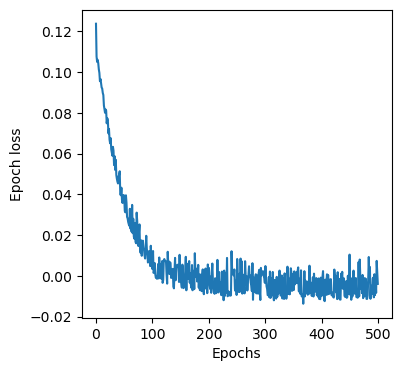

training_loss -0.00392101680607566
Average pos.mean:0.1608993411064148, Average pos_var: 0.013326304964721203
(26,)

------------------Beta_elbo:8.000000000000001e-06, Exploration Step:2 ----------------------- 
78


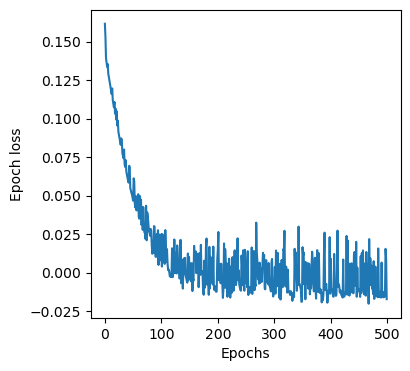

training_loss -0.01731613173551815
Average pos.mean:0.14246872067451477, Average pos_var: 0.010646682232618332
(27,)

------------------Beta_elbo:6.400000000000001e-06, Exploration Step:3 ----------------------- 
81


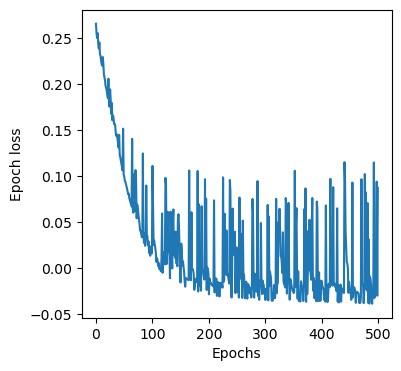

training_loss 0.08716404047302614
Average pos.mean:0.1567915678024292, Average pos_var: 0.008970586583018303
(28,)

------------------Beta_elbo:5.120000000000002e-06, Exploration Step:4 ----------------------- 
84


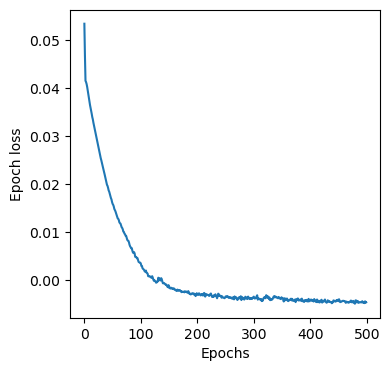

training_loss -0.0046290810345373115
Average pos.mean:0.08090493083000183, Average pos_var: 0.007347395643591881
(29,)

------------------Beta_elbo:4.096000000000002e-06, Exploration Step:5 ----------------------- 
87


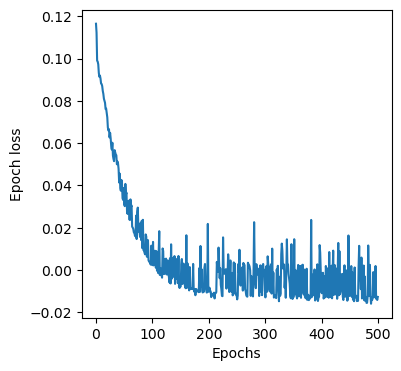

training_loss -0.012662444107137105
Average pos.mean:0.10147707164287567, Average pos_var: 0.005255716387182474
(30,)

------------------Beta_elbo:3.276800000000002e-06, Exploration Step:6 ----------------------- 
90


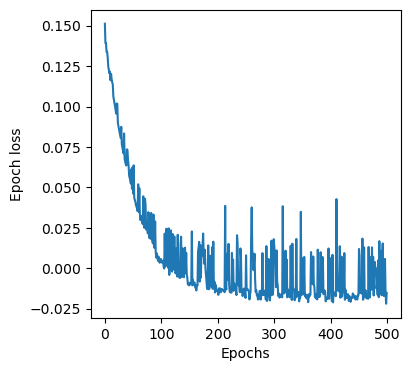

training_loss -0.01525852479312734
Average pos.mean:0.10937051475048065, Average pos_var: 0.007707836106419563
(31,)

------------------Beta_elbo:2.6214400000000015e-06, Exploration Step:7 ----------------------- 
93


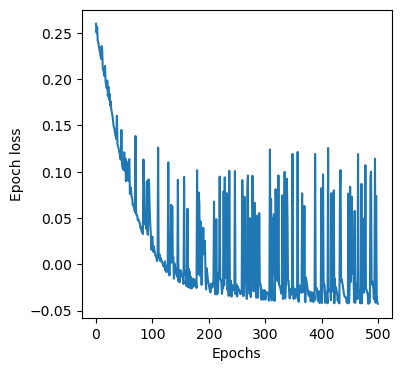

training_loss -0.04250237343481731
Average pos.mean:0.15929603576660156, Average pos_var: 0.006019999273121357
(32,)

------------------Beta_elbo:2.0971520000000012e-06, Exploration Step:8 ----------------------- 
96


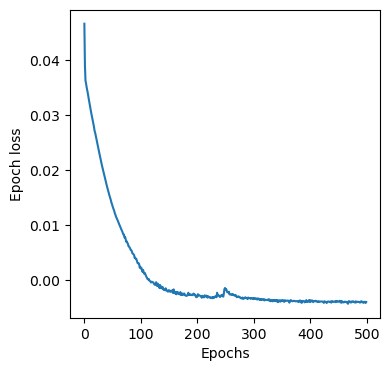

training_loss -0.003988077908962922
Average pos.mean:0.07126317173242569, Average pos_var: 0.004769030958414078
(33,)

------------------Beta_elbo:1.6777216000000011e-06, Exploration Step:9 ----------------------- 
99


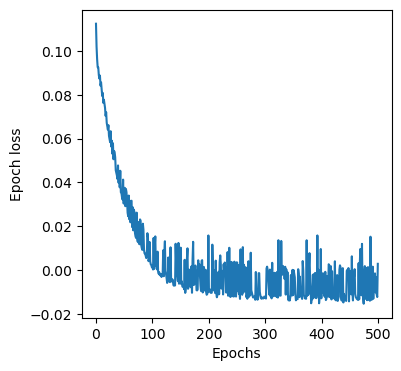

training_loss 0.002873227665613172
Average pos.mean:0.0977768674492836, Average pos_var: 0.00616130605340004
(34,)

------------------Beta_elbo:1.342177280000001e-06, Exploration Step:10 ----------------------- 
102


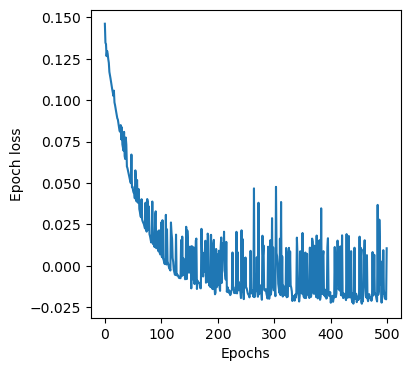

training_loss 0.01059411872531081
Average pos.mean:0.09664919227361679, Average pos_var: 0.005045098718255758
(35,)

------------------Beta_elbo:1.073741824000001e-06, Exploration Step:11 ----------------------- 
105


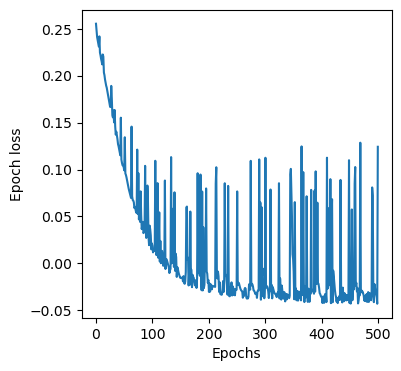

training_loss 0.12426381336092411
Average pos.mean:0.09864705055952072, Average pos_var: 0.005311841610819101
(36,)

------------------Beta_elbo:8.589934592000008e-07, Exploration Step:12 ----------------------- 
108


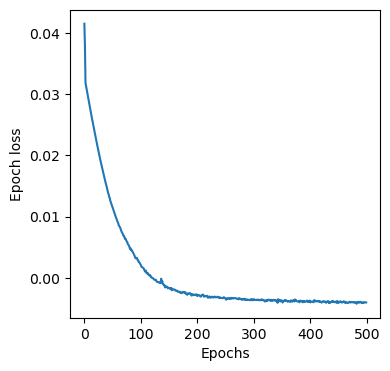

training_loss -0.004010594588210536
Average pos.mean:0.07992996275424957, Average pos_var: 0.004670077934861183
(37,)

------------------Beta_elbo:6.871947673600007e-07, Exploration Step:13 ----------------------- 
111


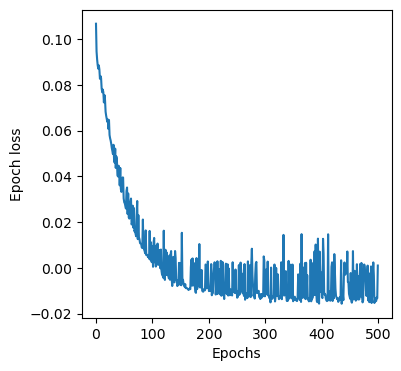

training_loss 0.0010508671724464118
Average pos.mean:0.11187627166509628, Average pos_var: 0.005199005361646414
(38,)

------------------Beta_elbo:5.497558138880006e-07, Exploration Step:14 ----------------------- 
114


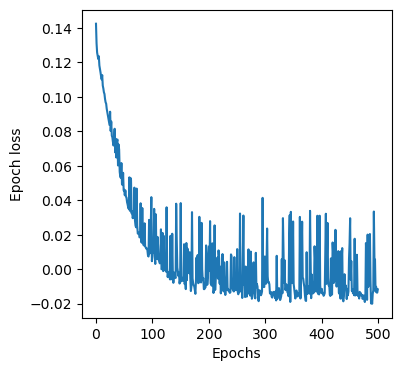

training_loss -0.011730123281965548
Average pos.mean:0.1236148253083229, Average pos_var: 0.009881077334284782
(39,)

------------------Beta_elbo:4.3980465111040047e-07, Exploration Step:15 ----------------------- 
117


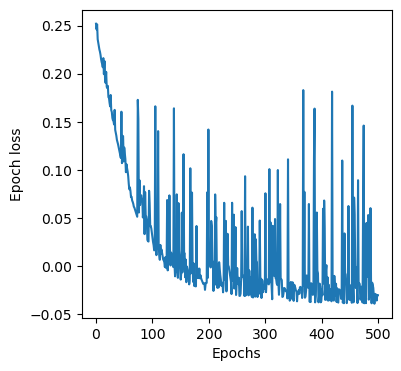

training_loss -0.030191444505046128
Average pos.mean:0.09472070634365082, Average pos_var: 0.008433149196207523
(40,)

------------------Beta_elbo:3.518437208883204e-07, Exploration Step:16 ----------------------- 
120


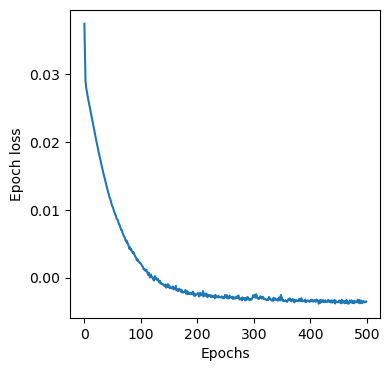

training_loss -0.0035119941239082253
Average pos.mean:0.12634870409965515, Average pos_var: 0.006945005152374506
(41,)

------------------Beta_elbo:2.8147497671065634e-07, Exploration Step:17 ----------------------- 
123


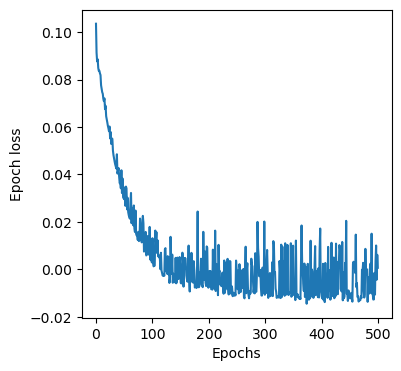

training_loss 0.0006364188622390053
Average pos.mean:0.1704980432987213, Average pos_var: 0.007687699981033802
(42,)

------------------Beta_elbo:2.2517998136852508e-07, Exploration Step:18 ----------------------- 
126


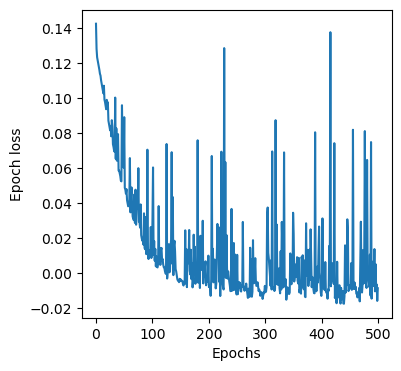

training_loss -0.008785453734360408
Average pos.mean:0.1416989117860794, Average pos_var: 0.0143961226567626
(43,)

------------------Beta_elbo:1.8014398509482007e-07, Exploration Step:19 ----------------------- 
129


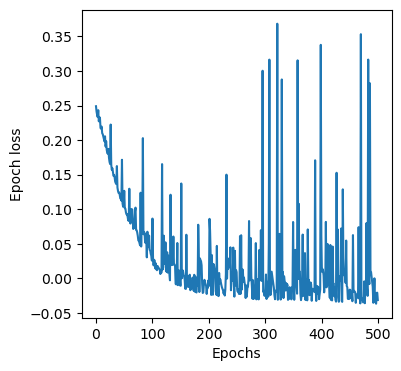

training_loss -0.031334723355295385
Average pos.mean:0.1384744793176651, Average pos_var: 0.009139367379248142
(44,)

------------------Beta_elbo:1.4411518807585607e-07, Exploration Step:20 ----------------------- 
132


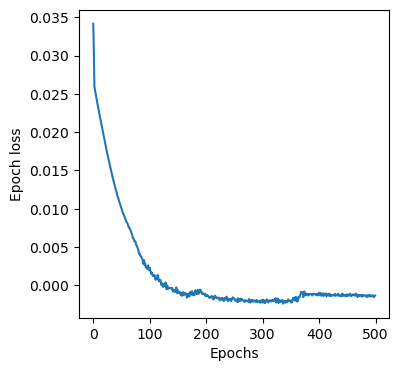

training_loss -0.0013305638601520502
Average pos.mean:0.13463722169399261, Average pos_var: 0.008761806413531303
(45,)

------------------Beta_elbo:1.1529215046068486e-07, Exploration Step:21 ----------------------- 
135


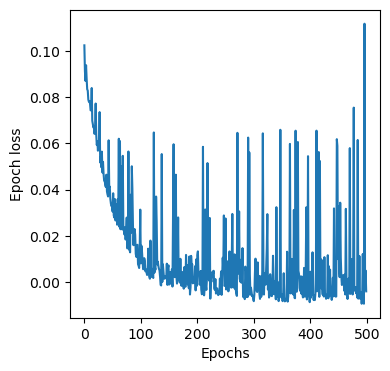

training_loss -0.004032068994553143
Average pos.mean:0.15702955424785614, Average pos_var: 0.014222401194274426
(46,)

------------------Beta_elbo:9.22337203685479e-08, Exploration Step:22 ----------------------- 
138


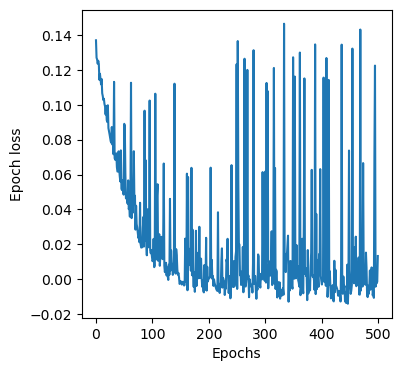

training_loss 0.013237204001350108
Average pos.mean:0.1773807257413864, Average pos_var: 0.016432270407676697
(47,)

------------------Beta_elbo:7.378697629483832e-08, Exploration Step:23 ----------------------- 
141


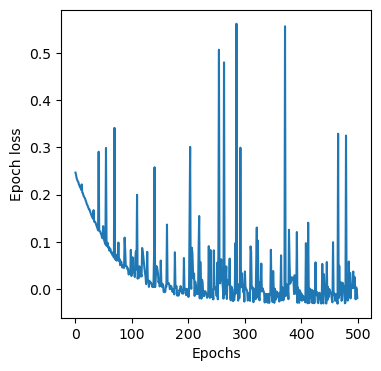

training_loss -0.019472400306893102
Average pos.mean:0.1578991860151291, Average pos_var: 0.015420312993228436
(48,)

------------------Beta_elbo:5.9029581035870656e-08, Exploration Step:24 ----------------------- 
144


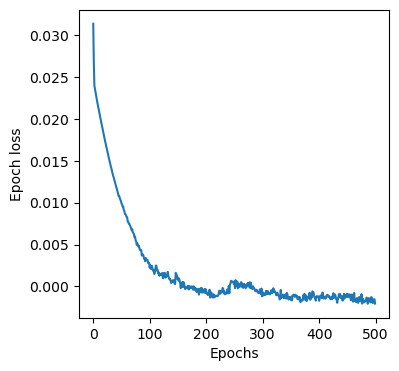

training_loss -0.0020518260852861944
Average pos.mean:0.10508733987808228, Average pos_var: 0.006208834238350391
(49,)

------------------Beta_elbo:4.722366482869653e-08, Exploration Step:25 ----------------------- 
147


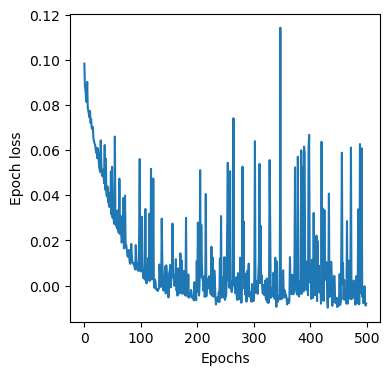

training_loss -0.007994841885333167
Average pos.mean:0.13633199036121368, Average pos_var: 0.008169521577656269
(50,)

------------------Beta_elbo:3.7778931862957224e-08, Exploration Step:26 ----------------------- 
150


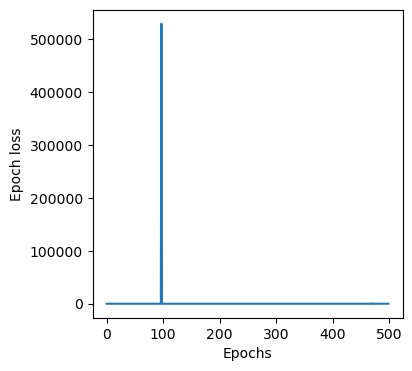

training_loss -0.010560735319740605
Average pos.mean:0.1440115123987198, Average pos_var: 0.0031312191858887672
(51,)

------------------Beta_elbo:3.022314549036578e-08, Exploration Step:27 ----------------------- 
153


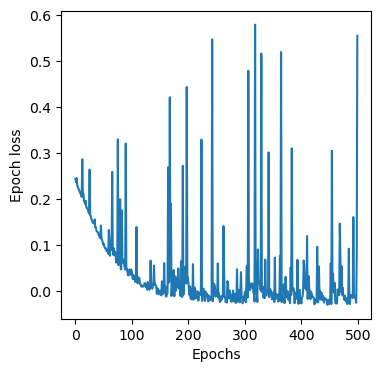

training_loss 0.5549784860646342
Average pos.mean:0.2069864571094513, Average pos_var: 0.015934808179736137
(52,)

------------------Beta_elbo:2.4178516392292625e-08, Exploration Step:28 ----------------------- 
156


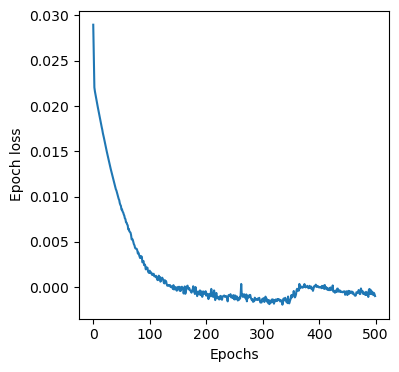

training_loss -0.0009711268160671516
Average pos.mean:0.14871709048748016, Average pos_var: 0.006447921507060528
(53,)

------------------Beta_elbo:1.93428131138341e-08, Exploration Step:29 ----------------------- 
159


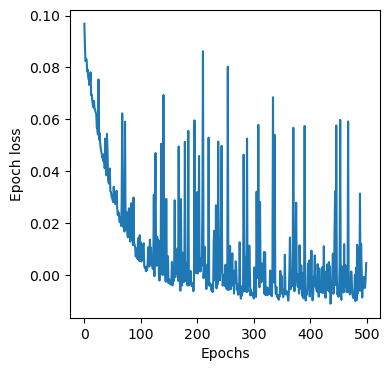

training_loss 0.004724281753360734
Average pos.mean:0.1723380833864212, Average pos_var: 0.011503149755299091
(54,)

------------------Beta_elbo:1.5474250491067282e-08, Exploration Step:30 ----------------------- 
162


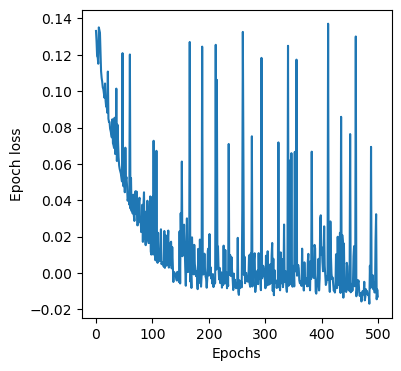

training_loss -0.012947775308171794
Average pos.mean:0.17055583000183105, Average pos_var: 0.01355317048728466
(55,)

------------------Beta_elbo:1.2379400392853826e-08, Exploration Step:31 ----------------------- 
165


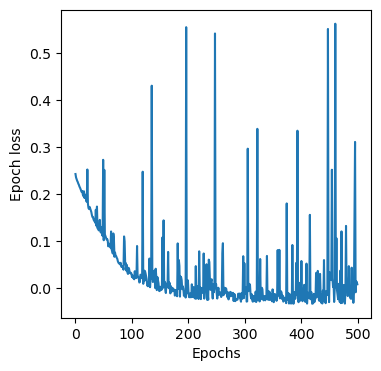

training_loss 0.008081348643310591
Average pos.mean:0.19758240878582, Average pos_var: 0.011811945587396622
(56,)

------------------Beta_elbo:9.903520314283061e-09, Exploration Step:32 ----------------------- 
168


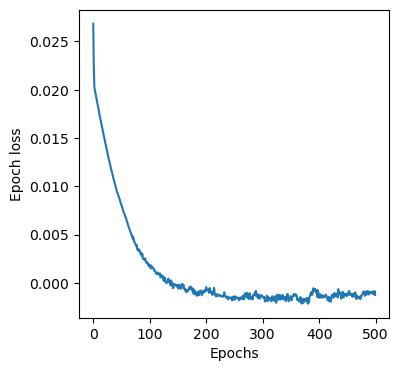

training_loss -0.001247844575403854
Average pos.mean:0.09131822735071182, Average pos_var: 0.005231975112110376
(57,)

------------------Beta_elbo:7.92281625142645e-09, Exploration Step:33 ----------------------- 
171


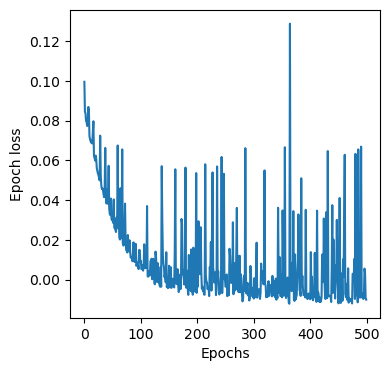

training_loss -0.010148102430439683
Average pos.mean:0.13821861147880554, Average pos_var: 0.0050002713687717915
(58,)

------------------Beta_elbo:6.33825300114116e-09, Exploration Step:34 ----------------------- 
174


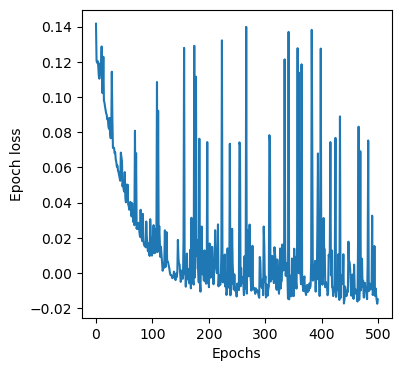

training_loss -0.015060958454188048
Average pos.mean:0.14842428267002106, Average pos_var: 0.011133909225463867
(59,)

------------------Beta_elbo:5.070602400912928e-09, Exploration Step:35 ----------------------- 
177


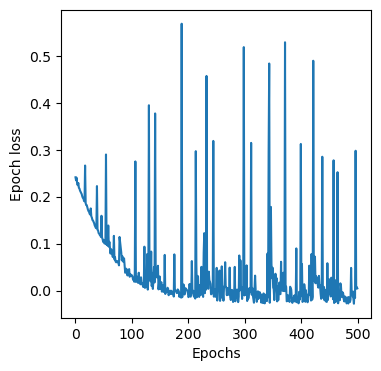

training_loss 0.004743823073481637
Average pos.mean:0.17348335683345795, Average pos_var: 0.018155371770262718
(60,)

------------------Beta_elbo:4.056481920730343e-09, Exploration Step:36 ----------------------- 
180


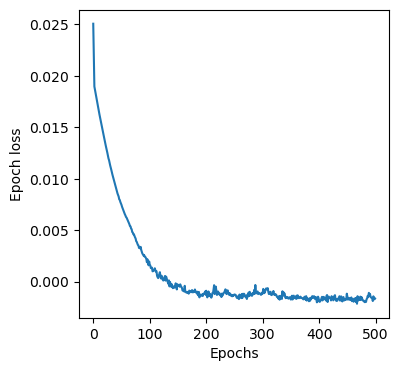

training_loss -0.0016328476165535899
Average pos.mean:0.21635138988494873, Average pos_var: 0.030486317351460457
(61,)

------------------Beta_elbo:3.2451855365842743e-09, Exploration Step:37 ----------------------- 
183


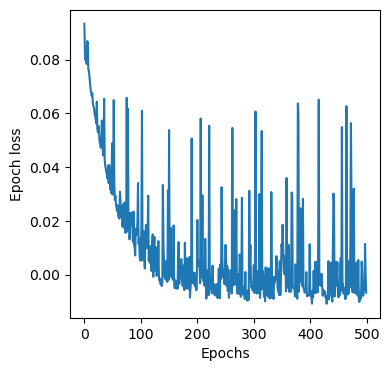

training_loss -0.006719604948685401
Average pos.mean:0.13191403448581696, Average pos_var: 0.012906250543892384
(62,)

------------------Beta_elbo:2.5961484292674197e-09, Exploration Step:38 ----------------------- 
186


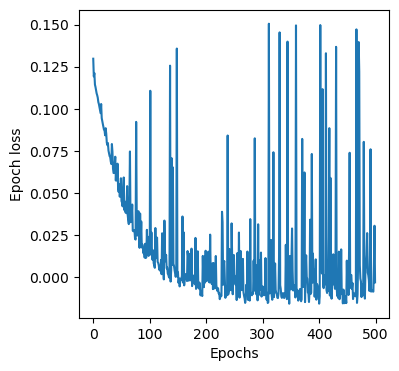

training_loss -0.0030443017059401216
Average pos.mean:0.15819068253040314, Average pos_var: 0.014959346503019333
(63,)

------------------Beta_elbo:2.0769187434139358e-09, Exploration Step:39 ----------------------- 
189


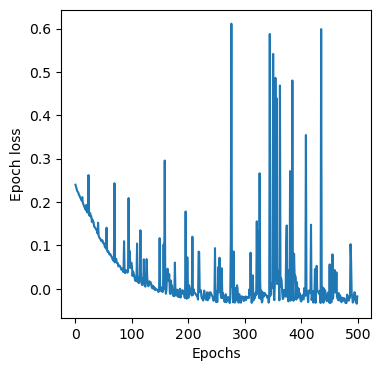

training_loss -0.01762007894628347
Average pos.mean:0.1423483043909073, Average pos_var: 0.011763593181967735
(64,)

------------------Beta_elbo:1.6615349947311487e-09, Exploration Step:40 ----------------------- 
192


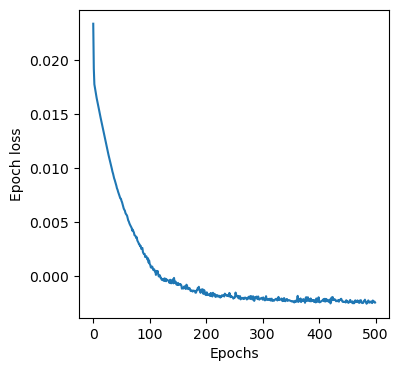

training_loss -0.0024199089476646556
Average pos.mean:0.05811227113008499, Average pos_var: 0.004544537980109453
(65,)

------------------Beta_elbo:1.329227995784919e-09, Exploration Step:41 ----------------------- 
195


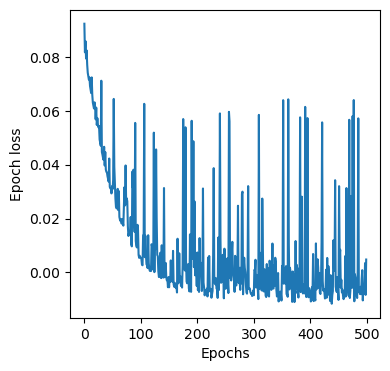

training_loss 0.004778947991628162
Average pos.mean:0.13440027832984924, Average pos_var: 0.012287086807191372
(66,)

------------------Beta_elbo:1.0633823966279352e-09, Exploration Step:42 ----------------------- 
198


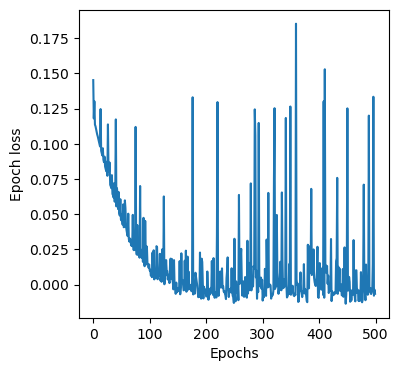

training_loss -0.006473940882638756
Average pos.mean:0.18560169637203217, Average pos_var: 0.024893203750252724
(67,)

------------------Beta_elbo:8.507059173023482e-10, Exploration Step:43 ----------------------- 
201


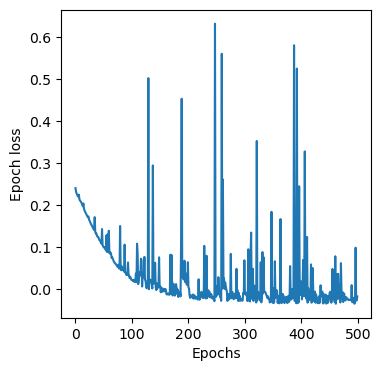

training_loss -0.016929220441594783
Average pos.mean:0.1581624150276184, Average pos_var: 0.012233970686793327
(68,)

------------------Beta_elbo:6.805647338418786e-10, Exploration Step:44 ----------------------- 
204


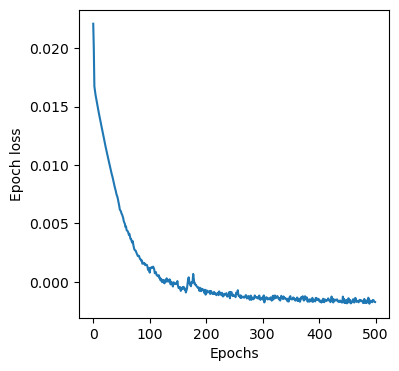

training_loss -0.0017361901712533412
Average pos.mean:0.3833082318305969, Average pos_var: 0.00920823123306036
(69,)

------------------Beta_elbo:5.444517870735029e-10, Exploration Step:45 ----------------------- 
207


Training:  36%|██████           | 180/500 [02:07<03:42,  1.44it/s, Loss=0.00451]

In [ ]:
for beta_elbo in beta_elbos:

    # Initialize trainset

    train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, 
                                                                                                           indices, 
                                                                                                           test_size=initial_test_fraction, 
                                                                                                           random_state = random_state)
    
    initial_trainsize = train_indices.shape[0]

    #train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    



    al_scores = []
    ran_scores = []

    for i in range(exploration_steps):

        print(f"\n------------------Beta_elbo:{beta_elbo}, Exploration Step:{i+1} ----------------------- ")

        custom_nn = VE_Mixed_LSTMCNN_FeatureExtractor(output_dim = 6)

        device  = "cuda" if torch.cuda.is_available() else 'cpu'

        #train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
        
        #trainset x3 
        train_dataset = augmented_dataset(train_X, train_params, train_y)
        print(len(train_dataset))

        # Contruct the GP surrogate function
        model, training_loss = train_mixed_nn_veDKL(train_dataset, custom_nn, lr_custom_nn = lr_custom_nn, lr_gp = lr_gp, 
                                                    num_epochs = n_epochs, device= device, n_batches = n_batches, 
                                                    plot_loss = True, beta_elbo = beta_elbo, lambda_c = lambda_c, lambda_s = lambda_s,
                                                   margin_c = margin_c)
        print("training_loss", training_loss[-1])

        # Calculate the predicted posterior mean and variance
        y_means, y_vars, lat_embeddings = veDKL_posterior(model, X, params = params)

        print(f"Average pos.mean:{y_means.mean()}, Average pos_var: {y_vars.mean()}")

        # Calculate the acquisition function
        #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)


        acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices, sample_next_points = sample_next_points)
        
        beta = decay_fac*beta
        beta_elbo = decay_fac*beta_elbo

        # best estimates
        #X_best_train, X_best_pred = best_mean_estimate(train_X, train_y, X, y_means)


        for ind in acq_ind:

            # Acquire next point

            next_score = score[ind].detach().numpy().squeeze()
            al_scores.append(next_score)


            ran_ind = random.choice(test_indices)
            ran_score = score[ran_ind].detach().numpy().squeeze()
            ran_scores.append(ran_score)

    #         print("Next-index: ",ind)
    #         print("Measured score: ", next_score)

            #Update training data
            train_X, train_y, train_params, train_indices = append_to_train(X, y, params, train_X, train_y, train_params, train_indices, ind)
            test_indices = np.delete(test_indices, np.where(test_indices == ind))



        print(train_indices.shape)

    al_scores = np.asarray(al_scores)
    ran_scores = np.asarray(ran_scores)
    
       
    # Save trainindices
    
    np.savetxt(os.path.join(save_folder, f'train_indices_betaelbo{beta_elbo}.txt'), train_indices.T)
    
    
    # Savefigure
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))

    print("Intitial_dataset_score:", score[train_indices[0:initial_trainsize]].mean())

    ax[0].plot(ran_scores, label = 'Random sampling')
    ax[0].plot(al_scores, label = 'Active Learning')
    ax[0].legend()

    ax[1].hist(ran_scores, bins=20, alpha=0.5, label=f'Random sampling\nAvg_score:{ran_scores.mean():.3f}', color='blue', edgecolor='black')
    ax[1].hist(al_scores, bins=20, alpha=0.5, label=f'Active Learning\nAvg_score:{al_scores.mean():.3f}', color='red', edgecolor='black')
    ax[1].legend()

    plt.savefig(os.path.join(save_folder, f'scorehist_betaelbo{beta_elbo}.jpg'), bbox_inches = 'tight')
    plt.show()
    
    
    
    # PCA of latent space
    
    embeddings = lat_embeddings.cpu().detach().numpy().squeeze()
    print(embeddings.shape)
    n, lat_dim = embeddings.shape
    ndim = int(n**0.5)
    x = np.arange(lat_dim)

    n_components=3
    pca = PCA(n_components=n_components)
    pca.fit(embeddings)
    eigenvalues=pca.fit_transform(embeddings)

    #we plot the variance explained
    plt.plot(pca.explained_variance_ratio_,'-o')
    plt.yscale("log")
    plt.title('Variance explained')
    plt.show()

    plt.figure(figsize=(5,5))
    #We plot the eigenvectors
    for i in range(n_components):

        plt.plot(x,pca.components_[i,:], 'o-', linewidth = 2, label="Component "+str(i+1))
    plt.title('Eigenvectors')
    plt.xlabel('Latent neuron', size = 16)
    plt.ylabel('Activation (a.u)', size = 16)


    plt.legend(fontsize = "large")
    plt.savefig(os.path.join(save_folder, f'PCAcomps_betaelbo{beta_elbo}.jpg'), bbox_inches = 'tight')
    plt.show()

    
    # Plot and save latent space
    
    img_path = os.path.join(save_folder, f'latent_space_betaelbo{beta_elbo}.jpg')
    plot_latent_space(eigenvalues, score, lat_order = [0, 1, 2], save_img_path = img_path)
    
    
    
    
    
    

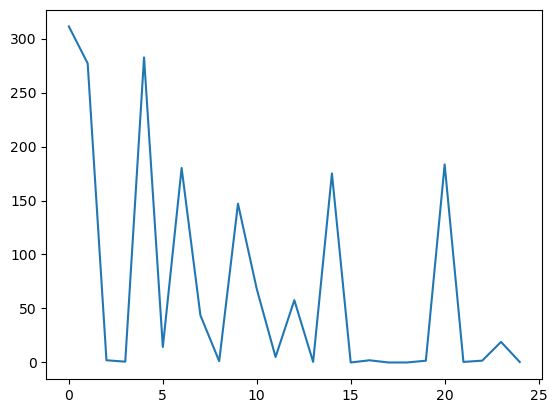

In [30]:
plt.plot(score[0:initial_trainsize])

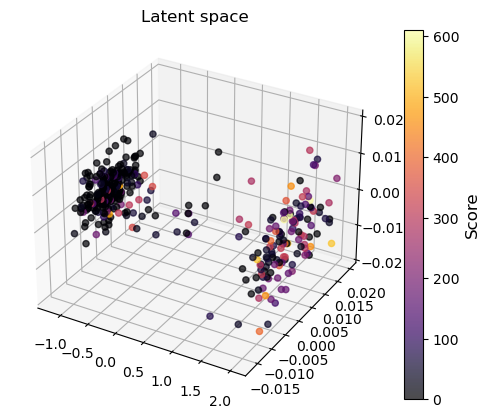

In [24]:
#plot_latent_space(eigenvalues, score, lat_order = [0, 1, 2], save_img_path = img_path)